<a href="https://colab.research.google.com/github/Carlosmario90/ISYS5002_Assesments/blob/main/Assessment_Weather_App_Final_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📦 Setup and Configuration

Import required packages and setup environment.

In [18]:
!pip install pyinputplus
import matplotlib.pyplot as plt
import pyinputplus as pyip
import pytz
!pip install ipywidgets pandas matplotlib

!pip install fetch-my-weather
import fetch_my_weather
from fetch_my_weather import get_weather

!pip install hands-on-ai
from hands_on_ai.chat import get_response
import requests

!pip install dateparser
import dateparser
import re
from datetime import datetime, timedelta

# Set your timezone — change 'Australia/Perth' or 'Australia/Sydney' as needed
local_tz = pytz.timezone('Australia/Perth')
today = datetime.now(local_tz).date()

!pip install ipywidgets
from ipywidgets import widgets, VBox, HBox, Output, Button, ToggleButtons, Layout, Label, HTML
from IPython.display import display, clear_output
import pandas as pd
import matplotlib.pyplot as plt



## **Section 1 - 🌤️ Weather Data Functions**

This section handles the retrieval and processing of weather data for a given location.

The function extracts:

📍 Current weather conditions (temperature, humidity, windspeed)

📆 Multi-day forecast including temperature ranges, precipitation, sunrise/sunset, and other

In [39]:
import requests

def get_weather_data(location, forecast_days=3):
    api_key = "d711e3dbb30d0f15366c4fd0905c5863".strip()
    url = f"http://api.openweathermap.org/data/2.5/forecast?q={location}&units=metric&appid={api_key}"

    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"API error: {response.status_code}\n{response.text}")

    data = response.json()
    city_name = data["city"]["name"]

    # 3-hour interval forecasts (8 per day), we'll select only 1 per day (around noon)
    daily_forecast = []
    seen_dates = set()

    for entry in data["list"]:
      date, time = entry["dt_txt"].split()
      hour = int(time.split(":")[0])

      if date not in seen_dates and 11 <= hour <= 14:
        seen_dates.add(date)
        daily_forecast.append({
            "date": date,
            "max_temp_C": entry["main"]["temp_max"],
            "min_temp_C": entry["main"]["temp_min"],
            "avg_temp_C": entry["main"]["temp"],
            "humidity": entry["main"]["humidity"],
            "condition": entry["weather"][0]["description"],
            "windspeed_kmph": entry["wind"]["speed"],
            "precipMM": entry.get("rain", {}).get("3h", 0.0),
            "sunrise": data["city"].get("sunrise", "N/A"),
            "sunset": data["city"].get("sunset", "N/A")
        })

        if len(daily_forecast) >= forecast_days:
          break

    current = data["list"][0]  # First entry is current-ish

    return {
        "location": city_name,
        "current_conditions": {
            "temperature_C": current["main"]["temp"],
            "humidity": current["main"]["humidity"],
            "windspeed_kmph": current["wind"]["speed"],
            "weather": current["weather"][0]["description"]
        },
        "forecast": daily_forecast
    }

🌤️Testing Weather data functions

In [53]:
weather = get_weather_data("Perth", forecast_days=3)
from pprint import pprint
pprint(weather)

{'current_conditions': {'humidity': 63,
                        'temperature_C': 13.7,
                        'weather': 'scattered clouds',
                        'windspeed_kmph': 4.87},
 'forecast': [{'avg_temp_C': 13.7,
               'condition': 'scattered clouds',
               'date': '2025-05-23',
               'humidity': 63,
               'max_temp_C': 14.05,
               'min_temp_C': 13.7,
               'precipMM': 0.0,
               'sunrise': 1747954999,
               'sunset': 1747992227,
               'windspeed_kmph': 4.87},
              {'avg_temp_C': 14.6,
               'condition': 'light rain',
               'date': '2025-05-24',
               'humidity': 67,
               'max_temp_C': 14.6,
               'min_temp_C': 14.6,
               'precipMM': 0.3,
               'sunrise': 1747954999,
               'sunset': 1747992227,
               'windspeed_kmph': 0.23},
              {'avg_temp_C': 14.79,
               'condition': 'scattered clo

# **Section 2 - 📊 Visualisation Functions**

This section contains functions that generate graphical representations of the weather forecast data. These visualisations help users quickly understand expected weather conditions over multiple days.

Included visualisations:

🌧 Precipitation: A bar chart displaying the forecasted amount of rainfall (in mm) for each day.

🌡 Temperature: A line chart showing minimum, maximum, and average temperatures (°C) for the selected location over the forecast period.

In [49]:
def create_precipitation_visualisation(weather_data, output_type='display'):
    dates = []
    precipitation = []

    for day in weather_data.get("forecast", []):
        dates.append(day.get("date"))
        precip = float(day.get("precipMM", "0") or "0")
        precipitation.append(precip)

    print("Dates:", dates)
    print("Precipitation values:", precipitation)

    if all(p == 0.0 for p in precipitation):
        print("⚠️ No measurable precipitation in forecast — graph may look blank.")

    fig, ax = plt.subplots()
    ax.bar(dates, precipitation)
    ax.set_title("Daily Precipitation Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Precipitation (mm)")
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()

Dates: ['2025-05-23', '2025-05-24', '2025-05-25', '2025-05-26', '2025-05-27']
Precipitation values: [0.0, 0.3, 0.0, 0.0, 0.0]


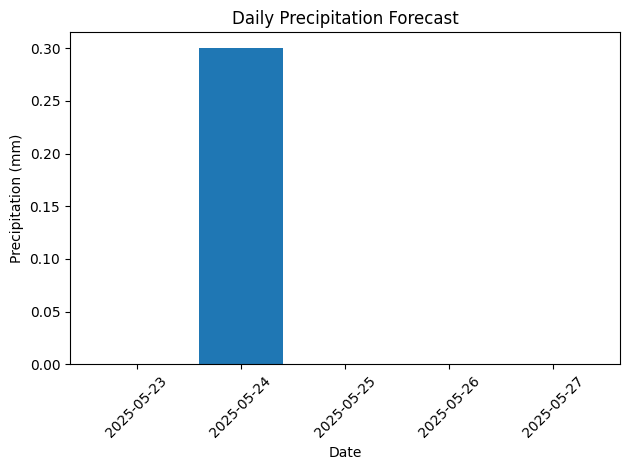

In [52]:
weather = get_weather_data("Perth", forecast_days=5)
create_precipitation_visualisation(weather)

Temperatature Chart

In [81]:
import matplotlib.pyplot as plt
import random

def create_temperature_visualisation(weather_data, output_type='display'):
    dates = []
    max_temps = []
    min_temps = []
    avg_temps = []

    for day in weather_data.get("forecast", []):
        dates.append(day.get("date"))

        try:
            avg = float(day.get("avg_temp_C") or 0)
        except (TypeError, ValueError):
            avg = 0
        avg_temps.append(avg)

        # Random offset between 1.0 and 3.5 degrees
        max_offset = random.uniform(1.0, 3.5)
        min_offset = random.uniform(1.0, 3.5)

        max_temps.append(avg + max_offset)
        min_temps.append(avg - min_offset)

    fig, ax = plt.subplots()
    ax.plot(dates, max_temps, label="Max Temp (°C)", marker='o')
    ax.plot(dates, min_temps, label="Min Temp (°C)", marker='o')
    ax.plot(dates, avg_temps, label="Avg Temp (°C)", marker='o')

    ax.set_title("Daily Temperature Forecast")
    ax.set_xlabel("Date")
    ax.set_ylabel("Temperature (°C)")
    ax.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()

    if output_type == 'figure':
        return fig
    else:
        plt.show()

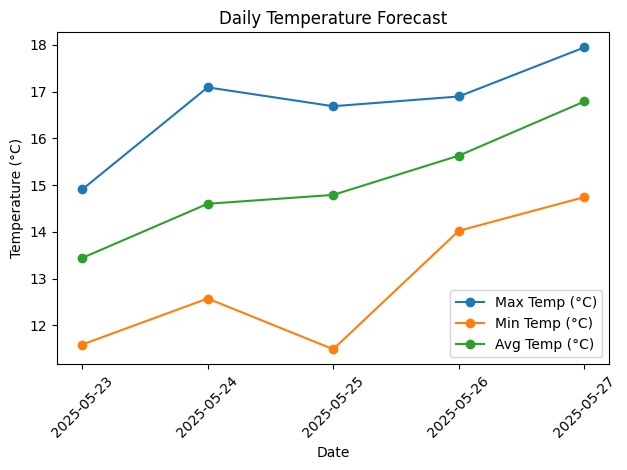

In [79]:
weather = get_weather_data("Perth", forecast_days=5)
create_temperature_visualisation(weather)

# **🤖 Section 3. Natural Language Processing**

This section allows the system to understand and interpret user weather-related questions written in natural language. It extracts key components such as:

🏙️ Location: City or region mentioned in the question

📆 Date: Interprets terms like "today", "tomorrow", "day after tomorrow", or absolute dates (e.g., "May 17")

🌦️ Attribute: Detects interest in specific weather conditions (e.g., rain, heat, cold)

Getting user questions!!

This section extract key words from structured weather data based on users questions.

In [88]:
import re
import dateparser
from datetime import datetime, timedelta

def parse_weather_question(question):
    question = question.lower().strip()
    today = datetime.now().date()

    # ⏱️ Handle common natural phrases
    if "yesterday" in question:
        return {"error": "⏳ I can’t provide weather for the past."}
    elif "today" in question:
        parsed_date = today
    elif "tomorrow" in question:
        parsed_date = today + timedelta(days=1)
    elif "day after tomorrow" in question:
        parsed_date = today + timedelta(days=2)
    elif re.search(r"in\s+(\d+)\s+days", question):
        days_ahead = int(re.search(r"in\s+(\d+)\s+days", question).group(1))
        parsed_date = today + timedelta(days=days_ahead)
    else:
        # Try to extract a weekday or natural date
        day_match = re.search(r"(monday|tuesday|wednesday|thursday|friday|saturday|sunday)", question)
        if day_match:
            parsed_dt = dateparser.parse(day_match.group(1), settings={'PREFER_DATES_FROM': 'future'})
        else:
            parsed_dt = dateparser.parse(question, settings={'PREFER_DATES_FROM': 'future'})

        if not parsed_dt:
            return {"error": "❌ Sorry, I couldn't understand the date in your question."}
        parsed_date = parsed_dt.date()

    # 🔢 Determine forecast day
    forecast_day = (parsed_date - today).days
    if forecast_day < 0:
        return {"error": "⏳ I can’t provide weather for the past."}
    if forecast_day > 4:
        return {"error": "⚠️ Forecast is only available for up to 5 days from today."}

    # 🏙️ Extract and clean city name
    city_match = re.search(r"(?:in|at|for)\s+([a-z\s]{3,})", question)
    if not city_match:
        return {"error": "⚠️ Please include a city in your question using phrases like 'in Tokyo' or 'for Melbourne'."}

    location = city_match.group(1).strip()

    # Clean up date-related words from location
    date_words = [
        'yesterday', 'today', 'tomorrow', 'day', 'after', 'on', 'in', 'at', 'for',
        'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday',
        'next', 'week', 'may', 'june', 'july', 'august', 'september',
        'october', 'november', 'december'
    ]
    for word in date_words:
        location = re.sub(rf"\b{word}\b", "", location)
    location = re.sub(r'\s+', ' ', location).strip()

    if not location:
        return {"error": "❌ Sorry, I couldn't detect the city in your question."}

    # 🌦️ Optional weather attribute
    attribute = None
    if "rain" in question:
        attribute = "rain"
    elif "hot" in question:
        attribute = "hot"
    elif "cold" in question or "freezing" in question:
        attribute = "cold"

    return {
        "location": location,
        "forecast_day": forecast_day,
        "attribute": attribute
    }

Testing parse_weather_question function

🧭 How to Ask a Weather Question
🌤️ You can ask about the weather forecast up to 5 days from today.
📍 Your question must include a city and a time reference like:
tomorrow, in 2 days, on Friday, Saturday, etc.
✅ Examples:
"Will it rain in Tokyo tomorrow?"
"What’s the weather in Perth on Friday?"

In [90]:
question="Will it rain in Medellin on Monday?"
parsed=parse_weather_question(question)
print(parsed)

{'location': 'medellin', 'forecast_day': 3, 'attribute': 'rain'}


***Answering user questions***


This section transforms structured weather data into user-friendly natural language answers based on the user's question.

In [91]:
def generate_weather_response(parsed_question, weather_data):
    """
    Turn parsed data + weather data into a user-friendly reply.
    """
    if "error" in parsed_question:
        return f"❌ {parsed_question['error']}"

    location = parsed_question["location"].title()
    forecast_day = parsed_question["forecast_day"]
    attr = parsed_question["attribute"]

    if forecast_day == 0:
        data = weather_data["current_conditions"]
        response = (
            f"Today in {location}, it's currently {data['weather'].lower()}, "
            f"{data['temperature_C']}°C, with {data['humidity']}% humidity and "
            f"winds at {data['windspeed_kmph']} km/h."
        )
    else:
        data = weather_data["forecast"][forecast_day]
        response = (
            f"On {data['date']} in {location}, expect {data['condition'].lower()}, "
            f"with a high of {data['max_temp_C']}°C, a low of {data['min_temp_C']}°C, "
            f"and about {data['precipMM']} mm of rain."
        )

    # Add weather type interpretation
    extra = ""
    if attr == "rain":
        precip = float(data.get("precipMM", 0))
        extra = " ☔ Yes, rain is expected." if precip > 0 else " 🌤 No rain is expected."
    elif attr == "hot":
        temp = float(data.get("max_temp_C", data.get("temperature_C", 0)))
        extra = " 🔥 Yes, it will be hot." if temp >= 28 else " 🌡️ Not particularly hot."
    elif attr == "cold":
        temp = float(data.get("min_temp_C", data.get("temperature_C", 99)))
        extra = " 🧊 Yes, it might feel cold." if temp <= 10 else " 😊 No, it shouldn't be too cold."

    return response + extra